## Installing the required packages

In [12]:
#!pip install transformers --quiet
#!pip install sentencepiece --quiet

## Importing required libraries

In [13]:
import pandas as pd
import os
import torch
import time
import warnings
import matplotlib.pyplot as plt
from itertools import chain
warnings.filterwarnings('ignore')

from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import Adafactor, AdamW
from IPython.display import HTML, display

In [ ]:
# Use this when working on Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


## Load the Pre-trained model T5 and the tokenizer

In [21]:
# Check GPU availability
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

# Uncomment this line to get the device name when working with CUDA
#print(torch.cuda.get_device_name(0))

# IMPORTANT: set the following variable to either 'small' or 'base' to train on T5 small or base
model_size = 'small'

# Instantiate three T5 models for the 3 datasets
model_t5_web_nlg = T5ForConditionalGeneration.from_pretrained(f't5-{model_size}', return_dict=True)
model_t5_e2e = T5ForConditionalGeneration.from_pretrained(f't5-{model_size}', return_dict=True)
model_t5_amr = T5ForConditionalGeneration.from_pretrained(f't5-{model_size}', return_dict=True)

# set the T5 tokenizer
tokenizer_t5 = T5Tokenizer.from_pretrained(f't5-{model_size}')

# Move the models to device(GPU/CPU)
model_t5_web_nlg.to(dev)
model_t5_e2e.to(dev)
model_t5_amr.to(dev)

Running on the CPU


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dro

## Preprocessing

In [22]:
load_no_duplicate_sets = True

# If you work on google colab upload the challenge datasets to your drive and change the paths below
# to load the datasets from drive

# Load the datasets for the Web NLG 2020 challenge
#train_data_web_nlg = pd.read_csv('drive/MyDrive/MIwDL/data/web_nlg/train/webNLG2020_train.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/web_nlg/train/webNLG2020_train_no_duplicate_inputs.csv')
#test_data_web_nlg = pd.read_csv('drive/MyDrive/MIwDL/data/web_nlg/test/webNLG2020_test.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/web_nlg/test/webNLG2020_test_no_duplicate_inputs.csv')

# Load the datasets for the Meaning Representation E2E challenge
#train_data_e2e = pd.read_csv('drive/MyDrive/MIwDL/data/e2e/train/trainset.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/e2e/train/trainset_no_duplicate_inputs.csv')
#test_data_e2e = pd.read_csv('drive/MyDrive/MIwDL/data/e2e/test/testset_w_refs.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/e2e/test/testset_no_duplicate_inputs.csv')

# Load the datasets for the Abstract Meaning Representation AMR challenge
#train_data_amr = pd.read_csv('drive/MyDrive/MIwDL/data/amr/abstract_meaning_representation_train.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/amr/train/amr_train_no_duplicate_inputs.csv')
#test_data_amr = pd.read_csv('drive/MyDrive/MIwDL/data/amr/abstract_meaning_representation_test.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/amr/test/amr_test_no_duplicate_inputs.csv')


# Load the datasets for the Web NLG 2020 challenge from the local project
train_data_web_nlg = pd.read_csv('data/web_nlg/train/webNLG2020_train.csv' if not load_no_duplicate_sets else 'data/web_nlg/train/webNLG2020_train_no_duplicate_inputs.csv')
test_data_web_nlg = pd.read_csv('data/web_nlg/test/webNLG2020_test.csv' if not load_no_duplicate_sets else 'data/web_nlg/test/webNLG2020_test_no_duplicate_inputs.csv')

# Load the datasets for the Meaning Representation E2E challenge
train_data_e2e = pd.read_csv('data/e2e/train/trainset.csv' if not load_no_duplicate_sets else 'data/e2e/train/trainset_no_duplicate_inputs.csv' )
test_data_e2e = pd.read_csv('data/e2e/test/testset_w_refs.csv' if not load_no_duplicate_sets else 'data/e2e/test/testset_no_duplicate_inputs.csv')

# Load the datasets for the Abstract Meaning Representation AMR challenge
train_data_amr = pd.read_csv('data/amr/train/abstract_meaning_representation_train.csv' if not load_no_duplicate_sets else 'data/amr/train/amr_train_no_duplicate_inputs.csv')
test_data_amr = pd.read_csv('data/amr/test/abstract_meaning_representation_test.csv' if not load_no_duplicate_sets else 'data/amr/test/amr_test_no_duplicate_inputs.csv')

In [23]:
# sort the values by ascending order
test_data_web_nlg = test_data_web_nlg.sort_values(by='input_text', ignore_index=True)
train_data_web_nlg = train_data_web_nlg.sort_values(by='input_text', ignore_index=True)

test_data_e2e = test_data_e2e.sort_values(by='input_text', ignore_index=True)
train_data_e2e = train_data_e2e.sort_values(by='input_text', ignore_index=True)

train_data_amr = train_data_amr.sort_values(by='input_text', ignore_index=True)
test_data_amr = test_data_amr.sort_values(by='input_text', ignore_index=True)

# Trimming off the last few datapoints from Web NLG so hat a batch would not leave any remainder.
train_data_web_nlg = train_data_web_nlg.iloc[:35200,:] if not load_no_duplicate_sets else train_data_web_nlg.iloc[:len(train_data_web_nlg)-3,:]
test_data_web_nlg = test_data_web_nlg.iloc[:1720,:] if not load_no_duplicate_sets else test_data_web_nlg.iloc[:len(test_data_web_nlg)-7,:]

# Trimming off the last few datapoints from E2E so that a batch would not leave any remainder.
train_data_e2e = train_data_e2e.iloc[:len(train_data_e2e)-1,:] if not load_no_duplicate_sets else train_data_e2e.iloc[:len(train_data_e2e)-6,:]
test_data_e2e = test_data_e2e.iloc[:len(test_data_e2e)-5,:] if not load_no_duplicate_sets else test_data_e2e.iloc[:len(test_data_e2e)-6,:]

# Trimming off the last few datapoints from AMR so that a batch would not leave any remainder.
train_data_amr = train_data_amr.iloc[:len(train_data_amr)-4,:] if not load_no_duplicate_sets else train_data_amr.iloc[:len(train_data_amr)-6,:]
test_data_amr = test_data_amr.iloc[:len(test_data_amr)-6,:] if not load_no_duplicate_sets else test_data_amr.iloc[:len(test_data_amr)-3,:]

In [24]:
# Set the batch sizes
batch_size_web_nlg = 8
batch_size_e2e = 8
batch_size_amr = 8

number_of_batches_train_web_nlg = int(len(train_data_web_nlg)/batch_size_web_nlg)
number_of_batches_test_web_nlg = int(len(test_data_web_nlg)/batch_size_web_nlg)

number_of_batches_train_e2e = int(len(train_data_e2e)/batch_size_e2e)
number_of_batches_test_e2e = int(len(test_data_e2e)/batch_size_e2e)

number_of_batches_train_amr = int(len(train_data_amr)/batch_size_amr)
number_of_batches_test_amr = int(len(test_data_amr)/batch_size_amr)

print('--- Number of train batches Web NLG: ' + str(number_of_batches_train_web_nlg) + ' --- ')
print('--- Number of test  batches Web NLG: ' + str(number_of_batches_test_web_nlg) + '  --- \n')

print('--- Number of train batches E2E : ' + str(number_of_batches_train_e2e) + ' --- ')
print('--- Number of test  batches E2E : ' + str(number_of_batches_test_e2e) + '  --- \n')

print('--- Number of train batches AMR : ' + str(number_of_batches_train_amr) + ' --- ')
print('--- Number of test  batches AMR : ' + str(number_of_batches_test_amr) + '  --- ')

--- Number of train batches Web NLG: 1640 --- 
--- Number of test  batches Web NLG: 74  --- 

--- Number of train batches E2E : 607 --- 
--- Number of test  batches E2E : 78  --- 

--- Number of train batches AMR : 168 --- 
--- Number of test  batches AMR : 18  --- 


In [25]:
# Create a List of batches for inputs and labels
def create_list_of_batches(batch_size, num_batches, data, tokenizer):
    inputs = []
    labels = []
    for i in range(num_batches):
        input_batch=[]
        label_batch=[]
        for index,row in data[i*batch_size:i*batch_size+batch_size].iterrows():
          input_batch.append('translate from Graph to Text: '+row['input_text']+'</s>')
          label_batch.append(row['target_text']+'</s>')

        input_batch=tokenizer.batch_encode_plus(input_batch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
        label_batch=tokenizer.batch_encode_plus(label_batch,padding=True,max_length=400,return_tensors='pt')["input_ids"]

        input_batch=input_batch.to(dev)
        label_batch=label_batch.to(dev)

        inputs.append(input_batch)
        labels.append(label_batch)
    return inputs, labels

inputs_train_web_nlg, labels_train_web_nlg = create_list_of_batches(batch_size=batch_size_web_nlg,
                                                                    num_batches=number_of_batches_train_web_nlg,
                                                                    data=train_data_web_nlg,
                                                                    tokenizer=tokenizer_t5)

inputs_test_web_nlg, labels_test_web_nlg = create_list_of_batches(batch_size=batch_size_web_nlg,
                                                                    num_batches=number_of_batches_test_web_nlg,
                                                                    data=test_data_web_nlg,
                                                                    tokenizer=tokenizer_t5)

inputs_train_e2e, labels_train_e2e = create_list_of_batches(batch_size=batch_size_e2e,
                                                                    num_batches=number_of_batches_train_e2e,
                                                                    data=train_data_e2e,
                                                                    tokenizer=tokenizer_t5)

inputs_test_e2e, labels_test_e2e = create_list_of_batches(batch_size=batch_size_e2e,
                                                                    num_batches=number_of_batches_test_e2e,
                                                                    data=test_data_e2e,
                                                                    tokenizer=tokenizer_t5)

inputs_train_amr, labels_train_amr = create_list_of_batches(batch_size=batch_size_amr,
                                                                    num_batches=number_of_batches_train_amr,
                                                                    data=train_data_amr,
                                                                    tokenizer=tokenizer_t5)

inputs_test_amr, labels_test_amr = create_list_of_batches(batch_size=batch_size_amr,
                                                                    num_batches=number_of_batches_test_amr,
                                                                    data=test_data_amr,
                                                                    tokenizer=tokenizer_t5)

## Set the Optimizer with Parameter values suggested for T5

In [26]:
# Change these parameters to try out different training approaches
def optimizer_adafactor(model, 
              lr=1e-3,
              eps=(1e-30, 1e-3),
              clip_threshold=1.0,
              decay_rate=-0.8,
              beta1=None,
              weight_decay=0.0,
              relative_step=False,   
              scale_parameter=False,
              warmup_init=False):
  
    return Adafactor(
        model.parameters(),
        lr=lr,
        eps=eps,
        clip_threshold=clip_threshold,
        decay_rate=decay_rate,
        beta1=beta1,
        weight_decay=weight_decay,
        relative_step=relative_step,
        scale_parameter=scale_parameter,
        warmup_init=warmup_init
    )

optimizer_t5_web_nlg = optimizer_adafactor(model_t5_web_nlg)
optimizer_t5_e2e     = optimizer_adafactor(model_t5_e2e)
optimizer_t5_amr     = optimizer_adafactor(model_t5_amr)

## Training Routine

In [27]:
# If you want to train longer set epochs accordingly
epochs = 20

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

def trainer(model, num_batches, inputs, labels, optimizer, challenge_name, model_name):
    # Set the model in training mode
    model.train()

    loss_per_10_steps=[]
    for epoch in range(1,epochs+1):
      print('Running epoch: {}'.format(epoch))
      running_loss=0

      out = display(progress(1, num_batches+1), display_id=True)
      for i in range(num_batches):

        # clear out the gradients of all Variables
        optimizer.zero_grad()

        # Forward propogation
        outputs = model(input_ids=inputs[i], labels=labels[i])
        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        if i%10 == 0: loss_per_10_steps.append(loss_num)
        out.update(progress(loss_num,i, num_batches+1))

        # calculating the gradients
        loss.backward()

        #updating the params
        optimizer.step()

      running_loss=running_loss/int(num_batches)
      print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))

      # plot the loss
      steps = [i for i in range(len(loss_per_10_steps))]
      plt.plot(steps, loss_per_10_steps)
      plt.title(f'Loss curve for the {challenge_name} challenge trained for {epochs} epochs on T5-{model_name}')
      plt.xlabel('Steps')
      plt.ylabel('Loss')
      plt.show()
    return model

In [28]:
# Again, if you want to train on T5 base uncomment/comment below cells

# Train T5 small on Web NLG
model_t5_web_nlg = trainer(model=model_t5_web_nlg, num_batches=number_of_batches_train_web_nlg, inputs=inputs_train_web_nlg, labels=labels_train_web_nlg, optimizer=optimizer_t5_web_nlg, challenge_name='Web NLG', model_name=f'{model_size}')

Running epoch: 1


KeyboardInterrupt: 

In [16]:
# Train T5 small on AMR
model_t5_amr = trainer(model=model_t5_amr,num_batches=number_of_batches_train_amr, inputs=inputs_train_amr, labels=labels_train_amr, optimizer=optimizer_t5_amr, challenge_name='AMR', model_name=f'{model_size}')

Traceback (most recent call last):
  File "/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug/pydev_jupyter_utils.py", line 69, in attach_to_debugger
    debugger.prepare_to_run(enable_tracing_from_start=False)
TypeError: prepare_to_run() got an unexpected keyword argument 'enable_tracing_from_start'
Failed to connect to target debugger.


Running epoch: 1


KeyboardInterrupt: 

Running epoch: 1


Epoch: 1 , Running loss: 1.0873962288240624


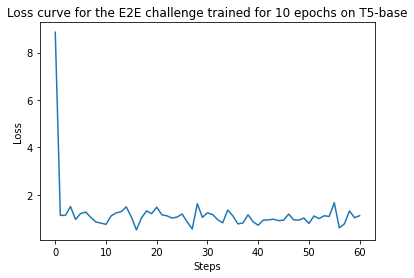

Running epoch: 2


Epoch: 2 , Running loss: 0.8770778500758836


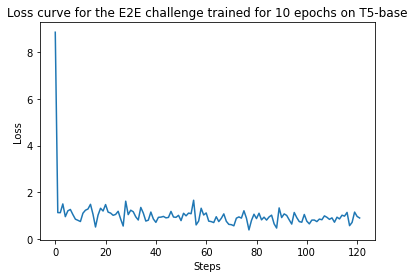

Running epoch: 3


Epoch: 3 , Running loss: 0.7898680811757114


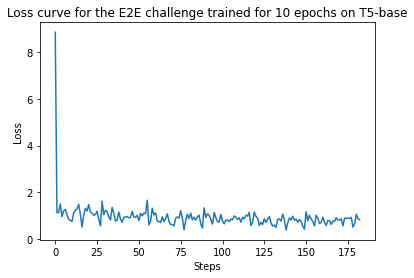

Running epoch: 4


Epoch: 4 , Running loss: 0.7208019140524762


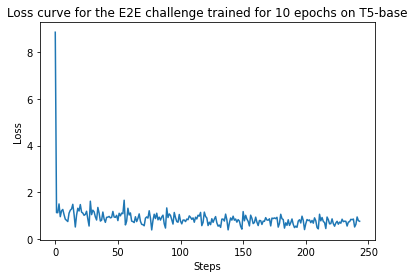

Running epoch: 5


Epoch: 5 , Running loss: 0.6643492721843562


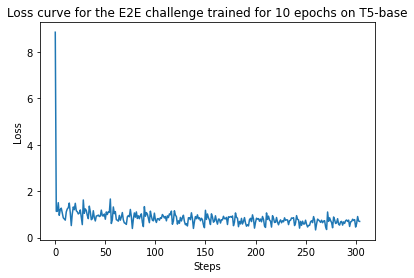

Running epoch: 6


Epoch: 6 , Running loss: 0.6139650265064821


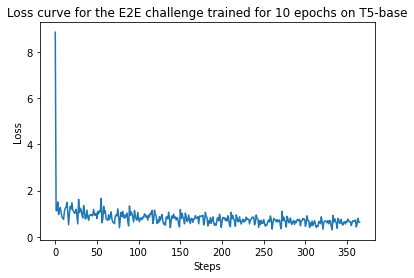

Running epoch: 7


Epoch: 7 , Running loss: 0.5703560613230779


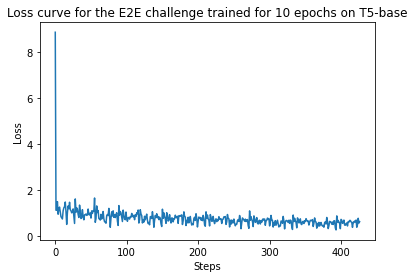

Running epoch: 8


Epoch: 8 , Running loss: 0.5247271598318264


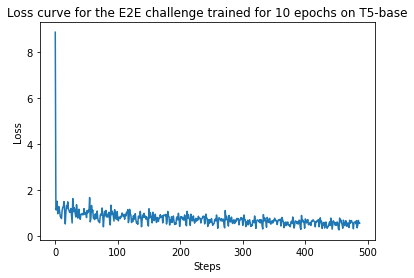

Running epoch: 9


Epoch: 9 , Running loss: 0.48549831441344304


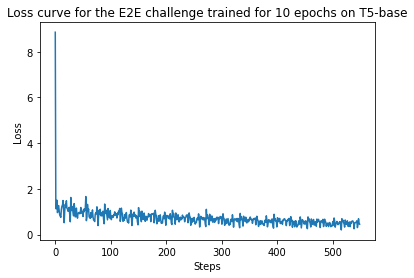

Running epoch: 10


Epoch: 10 , Running loss: 0.4485296572403617


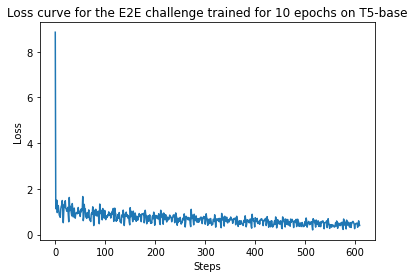

In [ ]:
# Train T5 small on E2E
model_t5_e2e = trainer(model=model_t5_e2e,  num_batches=number_of_batches_train_e2e, inputs=inputs_train_e2e, labels=labels_train_e2e, optimizer=optimizer_t5_e2e, challenge_name='E2E', model_name=f'{model_size}')

## Evaluate a Model

In [ ]:

# use this method to generate text for each test input ids, then save the predictions
# in a file 'hypothesis' for web nlg and amr to later use the official evaluation script for the 
# challenges
def make_predictions(model, inputs_test, tokenizer, challenge_name):

  model_predictions = []
  model.eval()
  with torch.no_grad():
    for i in range(len(inputs_test)):
      output = tokenizer.batch_decode(model.generate(inputs_test[i],
                                                     do_sample=True, 
                                                     max_length=400,
                                                     top_p=0.92,
                                                     top_k=0),
                                      skip_special_tokens=True)
      model_predictions.append([x.replace('<pad>','').replace('</s>','').strip() for x in output])

    # flatten the predictions list which has the length of batch_size * number_of_batches
    model_predictions = list(chain(*model_predictions))  
  model.train()

  # if you are working on colab set the path to which you want to save the output file
  #with open('drive/MyDrive/MIwDL/data/' + challenge_name + '/test/fine_tuning_hypothesis/hypothesis', 'w') as file:
  #  for i in range(len(model_predictions)):
  #    file.write(model_predictions[i] + '\n' if i < len(model_predictions)-1 else model_predictions[i])

  with open(f'data/{challenge_name}/test/fine_tuning_hypothesis/hypothesis', 'w') as file:
    for i in range(len(model_predictions)):
      file.write(model_predictions[i] + '\n' if i < len(model_predictions)-1 else model_predictions[i])

  return model_predictions

In [ ]:
# Again, if you want to train on T5 base uncomment/comment below cells

model_predictions = make_predictions(model=model_t5_web_nlg, inputs_test=inputs_test_web_nlg, tokenizer=tokenizer_t5, challenge_name='web_nlg')

In [ ]:
model_predictions = make_predictions(model=model_t5_amr, inputs_test=inputs_test_amr, tokenizer=tokenizer_t5, challenge_name='amr')

In [ ]:
model_predictions = make_predictions(model=model_t5_e2e,inputs_test=inputs_test_e2e,tokenizer=tokenizer_t5,challenge_name='e2e')

## Save the Model

In [ ]:
# To save a model, change the path accordingly
torch.save(model_t5_web_nlg.state_dict(),f'saved_models/t5_{model_size}/{epochs}_epochs_batch_size_{batch_size_web_nlg}_web_nlg.bin')

In [ ]:
torch.save(model_t5_e2e.state_dict(),f'saved_models/t5_{model_size}/{epochs}_epochs_batch_size_{batch_size_e2e}_e2e.bin')

In [ ]:
torch.save(model_t5_amr.state_dict(),f'saved_models/t5_{model_size}/{epochs}_epochs_batch_size_{batch_size_amr}_amr.bin')

## Load a model

In [ ]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json
#!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

# Specify the path to the saved model
model_t5_web_nlg = T5ForConditionalGeneration.from_pretrained(f'saved_models/t5_{model_size}/{epochs}_epochs_batch_size_{batch_size_web_nlg}_web_nlg.bin', return_dict=True, config=f't5-{model_size}-config.json')

if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

model_t5_web_nlg.to(dev)
tokenizer_t5_small = T5Tokenizer.from_pretrained(f't5-{model_size}')

--2022-01-08 19:00:24--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.94.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.94.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1197 (1.2K) [application/json]
Saving to: ‘t5-small-config.json.3’

t5-small-config.jso 100%[===================>]   1.17K  --.-KB/s    in 0s      

2022-01-08 19:00:24 (11.8 MB/s) - ‘t5-small-config.json.3’ saved [1197/1197]

Running on the GPU
